<a href="https://colab.research.google.com/github/Duy220599/Human-activity-regconition/blob/main/Final_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">
  <h1>Welcome to Colab!</h1>
</div>

If you're already familiar with Colab, check out this video to learn about interactive tables, the executed code history view, and the command palette.

<center>
  <a href="https://www.youtube.com/watch?v=rNgswRZ2C1Y" target="_blank">
  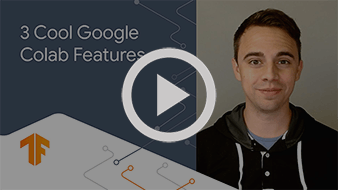
  </a>
</center>

<div class="markdown-google-sans">

## More Resources

### Working with Notebooks in Colab

</div>

- [Overview of Colaboratory](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)
- <img src="/img/new.png" height="20px" align="left" hspace="4px" alt="New"></img>

<div class="markdown-google-sans">

<a name="working-with-data"></a>
### Working with Data
</div>

- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb) 
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

<div class="markdown-google-sans">

### Machine Learning Crash Course

<div>

These are a few of the notebooks from Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Linear regression with tf.keras using synthetic data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)

<div class="markdown-google-sans">

<a name="using-accelerated-hardware"></a>
### Using Accelerated Hardware
</div>

- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TensorFlow with TPUs](/notebooks/tpu.ipynb)

<div class="markdown-google-sans">

<a name="machine-learning-examples"></a>

### Featured examples

</div>

- [NeMo Voice Swap](https://colab.research.google.com/github/NVIDIA/NeMo/blob/stable/tutorials/VoiceSwapSample.ipynb): Use Nvidia's NeMo conversational AI Toolkit to swap a voice in an audio fragment with a computer generated one.

- [Retraining an Image Classifier](https://tensorflow.org/hub/tutorials/tf2_image_retraining): Build a Keras model on top of a pre-trained image classifier to distinguish flowers.
- [Text Classification](https://tensorflow.org/hub/tutorials/tf2_text_classification): Classify IMDB movie reviews as either *positive* or *negative*.
- [Style Transfer](https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization): Use deep learning to transfer style between images.
- [Multilingual Universal Sentence Encoder Q&A](https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa): Use a machine learning model to answer questions from the SQuAD dataset.
- [Video Interpolation](https://tensorflow.org/hub/tutorials/tweening_conv3d): Predict what happened in a video between the first and the last frame.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import metrics
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Conv1D, MaxPooling1D,GlobalAveragePooling1D,GlobalAvgPool1D, Reshape, Activation
from keras import optimizers
import keras
from keras.utils import np_utils

In [ ]:
def read_data(file_path):
    column_names = ['user-id','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
    data = pd.read_csv(file_path,header = None, names = column_names)
    return data

In [ ]:
def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma

In [ ]:
dataset = read_data('data2.txt')
dataset.dropna(axis=0, how='any', inplace= True)
dataset = dataset.sort_values(by = ['user-id','timestamp'],ignore_index = True)
dataset['x-axis'] = feature_normalize(dataset['x-axis'])
dataset['y-axis'] = feature_normalize(dataset['y-axis'])
dataset['z-axis'] = feature_normalize(dataset['z-axis'])

In [ ]:
#DEFINE NETWORK PARAMETERS
trainSplitRatio = 0.7 # split ratio for test and validation
window_size = 50 #Length of time slice. 50 Hz in each sequence
numFilters1 = 100 # number of filters in first Conv1D layer
kernalSize = 10 # kernal size of the Conv2D layer
batchSize = 10
numNueronsFCL2 = 160 # number of filters in fully connected output layer 
dropout = 0.5 #dropout rate. % of neurons converted to 0 weight before softmax
epochs = 50 # number of iterations

In [ ]:
step = 10
N_TIME_STEPS = 50 
N_FEATURES = 3
segments = []
labels = []

for i in range(0,  dataset.shape[0]-N_TIME_STEPS, step):  
    xs = dataset['x-axis'].values[i: i + 50]
    ys = dataset['y-axis'].values[i: i + 50]
    zs = dataset['z-axis'].values[i: i + 50]
    label = stats.mode(dataset['activity'][i: i + 50])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

#reshape the segments which is (list of arrays) to one list
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(len(segments), N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)
reshaped_segments.shape

(109816, 50, 3)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size = 0.2, random_state = 20)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(87852, 50, 3) (87852, 6)
(21964, 50, 3) (21964, 6)


In [ ]:
numOfRows = reshaped_segments.shape[1]
numOfColumns = reshaped_segments.shape[2]
num_classes = labels.shape[1]
num_data_parameters = X_train.shape[2]
input_shape = window_size*num_data_parameters

print(input_shape)

150


In [ ]:
model_1 = Sequential()
model_1.add(Reshape((window_size, num_data_parameters), input_shape=(numOfRows,numOfColumns)))
model_1.add(Conv1D(numFilters1, kernalSize, activation='relu', input_shape=(window_size, num_data_parameters)))
model_1.add(MaxPooling1D(3))
model_1.add(Conv1D(numNueronsFCL2, 10, activation='relu'))
model_1.add(GlobalAveragePooling1D())

model_1.add(Dropout(dropout))

model_1.add(Dense(num_classes, activation='softmax'))
print(model_1.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_5 (Reshape)         (None, 50, 3)             0         
                                                                 
 conv1d_18 (Conv1D)          (None, 41, 100)           3100      
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 13, 100)          0         
 1D)                                                             
                                                                 
 conv1d_19 (Conv1D)          (None, 4, 160)            160160    
                                                                 
 global_average_pooling1d_9   (None, 160)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_9 (Dropout)         (None, 160)              

In [ ]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='loss', patience=1)
]

model_1.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 1024
EPOCHS = epochs

history_1 = model_1.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/50
69/69 [==============================] - 48s 688ms/step - loss: 0.8343 - accuracy: 0.6956 - val_loss: 0.5557 - val_accuracy: 0.7993
Epoch 2/50
69/69 [==============================] - 49s 710ms/step - loss: 0.5315 - accuracy: 0.8152 - val_loss: 0.4307 - val_accuracy: 0.8520
Epoch 3/50
69/69 [==============================] - 52s 755ms/step - loss: 0.4408 - accuracy: 0.8496 - val_loss: 0.3557 - val_accuracy: 0.8805
Epoch 4/50
69/69 [==============================] - 47s 684ms/step - loss: 0.3783 - accuracy: 0.8732 - val_loss: 0.3150 - val_accuracy: 0.8909
Epoch 5/50
69/69 [==============================] - 49s 707ms/step - loss: 0.3353 - accuracy: 0.8895 - val_loss: 0.2771 - val_accuracy: 0.9105
Epoch 6/50
69/69 [==============================] - 44s 640ms/step - loss: 0.3066 - accuracy: 0.8997 - val_loss: 0.2540 - val_accuracy: 0.9148
Epoch 7/50
69/69 [==============================] - 49s 707ms/step - loss: 0.2864 - accuracy: 0.9059 - val_loss: 0.2350 - val_accuracy: 0.9237

In [ ]:
score = model_1.evaluate(X_test,y_test,batch_size=BATCH_SIZE, verbose=2)
print("The test accuracy is",score[1]*100,"%")

22/22 - 1s - loss: 0.1131 - accuracy: 0.9626 - 991ms/epoch - 45ms/step
The test accuracy is 96.26206755638123 %


In [ ]:
model_2 = Sequential()
model_2.add(Reshape((window_size, num_data_parameters), input_shape=(numOfRows,numOfColumns)))
model_2.add(Conv1D(numFilters1, kernalSize, activation='relu', input_shape=(window_size, num_data_parameters)))
model_2.add(MaxPooling1D(3))
model_2.add(Conv1D(numNueronsFCL2, 10, activation='relu'))
model_2.add(GlobalAveragePooling1D())

model_2.add(Dropout(dropout))

model_2.add(Dense(num_classes, activation='softmax'))
print(model_2.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_6 (Reshape)         (None, 50, 3)             0         
                                                                 
 conv1d_20 (Conv1D)          (None, 41, 100)           3100      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 13, 100)          0         
 g1D)                                                            
                                                                 
 conv1d_21 (Conv1D)          (None, 4, 160)            160160    
                                                                 
 global_average_pooling1d_10  (None, 160)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_10 (Dropout)        (None, 160)             

In [ ]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='loss', patience=1)
]

model_2.compile(loss='categorical_crossentropy',
                optimizer='sgd', metrics=['accuracy'])

BATCH_SIZE = 1024
EPOCHS = epochs

history_2 = model_2.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/50
69/69 [==============================] - 57s 811ms/step - loss: 1.3564 - accuracy: 0.4809 - val_loss: 1.1750 - val_accuracy: 0.6248
Epoch 2/50
69/69 [==============================] - 50s 724ms/step - loss: 1.1326 - accuracy: 0.6166 - val_loss: 1.0227 - val_accuracy: 0.6828
Epoch 3/50
69/69 [==============================] - 44s 647ms/step - loss: 1.0058 - accuracy: 0.6730 - val_loss: 0.9128 - val_accuracy: 0.7008
Epoch 4/50
69/69 [==============================] - 48s 693ms/step - loss: 0.9220 - accuracy: 0.6953 - val_loss: 0.8429 - val_accuracy: 0.7136
Epoch 5/50
69/69 [==============================] - 51s 743ms/step - loss: 0.8625 - accuracy: 0.7062 - val_loss: 0.7955 - val_accuracy: 0.7199
Epoch 6/50
69/69 [==============================] - 48s 695ms/step - loss: 0.8230 - accuracy: 0.7135 - val_loss: 0.7608 - val_accuracy: 0.7242
Epoch 7/50
69/69 [==============================] - 49s 715ms/step - loss: 0.7940 - accuracy: 0.7199 - val_loss: 0.7335 - val_accuracy: 0.7281

In [ ]:
score = model_2.evaluate(X_test,y_test,batch_size=BATCH_SIZE, verbose=2)
print("The test accuracy is",score[1]*100,"%")

22/22 - 2s - loss: 0.4342 - accuracy: 0.8503 - 2s/epoch - 105ms/step
The test accuracy is 85.03004908561707 %


In [ ]:
model_3 = Sequential()
model_3.add(Reshape((window_size, num_data_parameters), input_shape=(numOfRows,numOfColumns)))
model_3.add(Conv1D(numFilters1, kernalSize, activation='relu', input_shape=(window_size, num_data_parameters)))
model_3.add(MaxPooling1D(3))
model_3.add(Conv1D(numNueronsFCL2, 10, activation='relu'))
model_3.add(GlobalAveragePooling1D())

model_3.add(Dropout(dropout))
model_3.add(Dense(num_classes, activation='softmax'))
print(model_3.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_7 (Reshape)         (None, 50, 3)             0         
                                                                 
 conv1d_22 (Conv1D)          (None, 41, 100)           3100      
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 13, 100)          0         
 g1D)                                                            
                                                                 
 conv1d_23 (Conv1D)          (None, 4, 160)            160160    
                                                                 
 global_average_pooling1d_11  (None, 160)              0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_11 (Dropout)        (None, 160)             

In [ ]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='loss', patience=1)
]

model_3.compile(loss='categorical_crossentropy',
                optimizer='adadelta', metrics=['accuracy'])

BATCH_SIZE = 1024
EPOCHS = epochs

history_3 = model_3.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/50
69/69 [==============================] - 55s 788ms/step - loss: 1.7543 - accuracy: 0.2052 - val_loss: 1.7052 - val_accuracy: 0.2780
Epoch 2/50
69/69 [==============================] - 51s 745ms/step - loss: 1.6975 - accuracy: 0.2605 - val_loss: 1.6503 - val_accuracy: 0.3157
Epoch 3/50
69/69 [==============================] - 48s 699ms/step - loss: 1.6455 - accuracy: 0.3033 - val_loss: 1.6002 - val_accuracy: 0.3287
Epoch 4/50
69/69 [==============================] - 45s 654ms/step - loss: 1.5964 - accuracy: 0.3410 - val_loss: 1.5544 - val_accuracy: 0.3293
Epoch 5/50
69/69 [==============================] - 42s 611ms/step - loss: 1.5556 - accuracy: 0.3591 - val_loss: 1.5125 - val_accuracy: 0.3329
Epoch 6/50
69/69 [==============================] - 49s 715ms/step - loss: 1.5138 - accuracy: 0.3776 - val_loss: 1.4743 - val_accuracy: 0.3470
Epoch 7/50
69/69 [==============================] - 46s 665ms/step - loss: 1.4774 - accuracy: 0.3938 - val_loss: 1.4398 - val_accuracy: 0.3744

In [ ]:
score = model_3.evaluate(X_test,y_test,batch_size=BATCH_SIZE, verbose=2)
print("The test accuracy is",score[1]*100,"%")

22/22 - 2s - loss: 0.9948 - accuracy: 0.6761 - 2s/epoch - 84ms/step
The test accuracy is 67.6106333732605 %


In [ ]:
model_4 = Sequential()
model_4.add(Reshape((window_size, num_data_parameters), input_shape=(numOfRows,numOfColumns)))
model_4.add(Conv1D(numFilters1, kernalSize, activation='relu', input_shape=(window_size, num_data_parameters)))
model_4.add(MaxPooling1D(3))
model_4.add(Conv1D(numNueronsFCL2, 10, activation='relu'))
model_4.add(GlobalAveragePooling1D())

model_4.add(Dropout(dropout))
model_4.add(Dense(128))
model_4.add(Dense(num_classes, activation='softmax'))
print(model_4.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 50, 3)             0         
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 100)           3100      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 13, 100)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 4, 160)            160160    
                                                                 
 global_average_pooling1d_1   (None, 160)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 160)              

In [ ]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='loss', patience=1)
]

model_4.compile(loss='categorical_crossentropy',
                optimizer='rmsprop', metrics=['accuracy'])

BATCH_SIZE = 1024
EPOCHS = epochs

history_4 = model_4.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/50
69/69 [==============================] - 48s 670ms/step - loss: 0.9169 - accuracy: 0.6709 - val_loss: 0.5646 - val_accuracy: 0.7895
Epoch 2/50
69/69 [==============================] - 43s 621ms/step - loss: 0.5735 - accuracy: 0.7979 - val_loss: 0.4915 - val_accuracy: 0.8127
Epoch 3/50
69/69 [==============================] - 40s 586ms/step - loss: 0.4905 - accuracy: 0.8285 - val_loss: 0.3799 - val_accuracy: 0.8677
Epoch 4/50
69/69 [==============================] - 43s 624ms/step - loss: 0.4351 - accuracy: 0.8496 - val_loss: 0.3469 - val_accuracy: 0.8772
Epoch 5/50
69/69 [==============================] - 40s 582ms/step - loss: 0.3836 - accuracy: 0.8694 - val_loss: 0.3531 - val_accuracy: 0.8689
Epoch 6/50
69/69 [==============================] - 44s 644ms/step - loss: 0.3510 - accuracy: 0.8812 - val_loss: 0.3098 - val_accuracy: 0.9061
Epoch 7/50
69/69 [==============================] - 44s 639ms/step - loss: 0.3241 - accuracy: 0.8902 - val_loss: 0.2643 - val_accuracy: 0.9190

In [ ]:
score = model_4.evaluate(X_test,y_test,batch_size=BATCH_SIZE, verbose=2)
print("The test accuracy is",score[1]*100,"%")

22/22 - 2s - loss: 0.1141 - accuracy: 0.9650 - 2s/epoch - 75ms/step
The test accuracy is 96.49881720542908 %


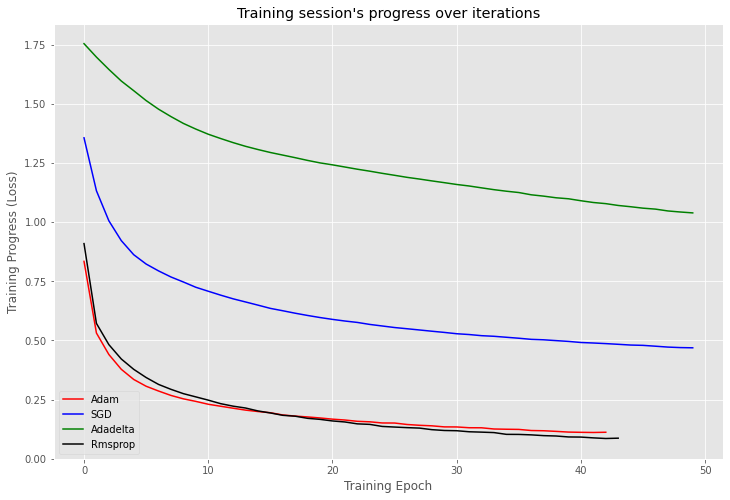

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(np.array(history_1.history['loss']), "r-", label = "Adam")
plt.plot(np.array(history_2.history['loss']), "b-", label = "SGD")
plt.plot(np.array(history_3.history['loss']), "g-", label = "Adadelta")
plt.plot(np.array(history_4.history['loss']), "#000000", label = "Rmsprop")
plt.title("Training session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

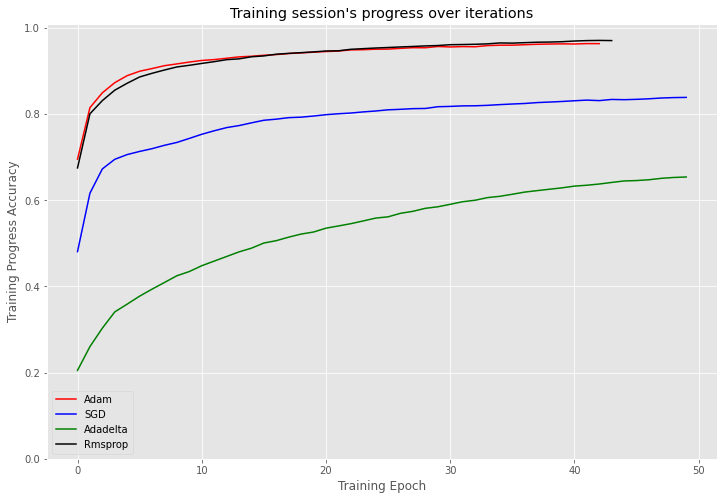

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(np.array(history_1.history['accuracy']), "r-", label = "Adam")
plt.plot(np.array(history_2.history['accuracy']), "b-", label = "SGD")
plt.plot(np.array(history_3.history['accuracy']), "g-", label = "Adadelta")
plt.plot(np.array(history_4.history['accuracy']), "#000000", label = "Rmsprop")
plt.title("Training session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Training Progress Accuracy')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

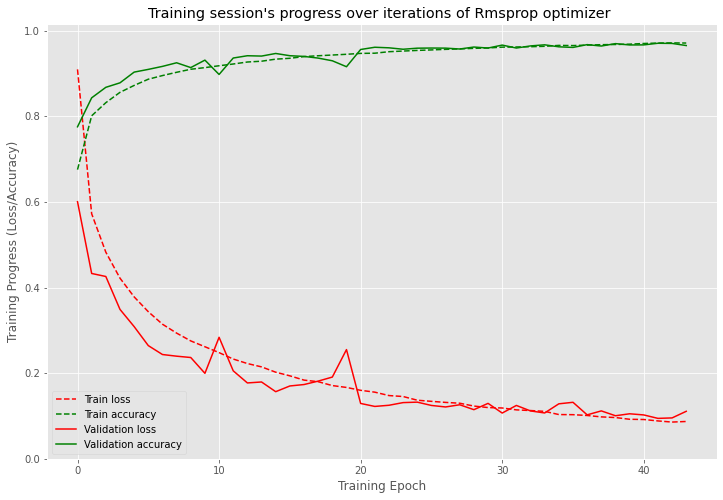

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(np.array(history_4.history['loss']), "r--", label = "Train loss")
plt.plot(np.array(history_4.history['accuracy']), "g--", label = "Train accuracy")
plt.plot(np.array(history_4.history['val_loss']), "r-", label = "Validation loss")
plt.plot(np.array(history_4.history['val_accuracy']), "g-", label = "Validation accuracy")
plt.title("Training session's progress over iterations of Rmsprop optimizer ")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

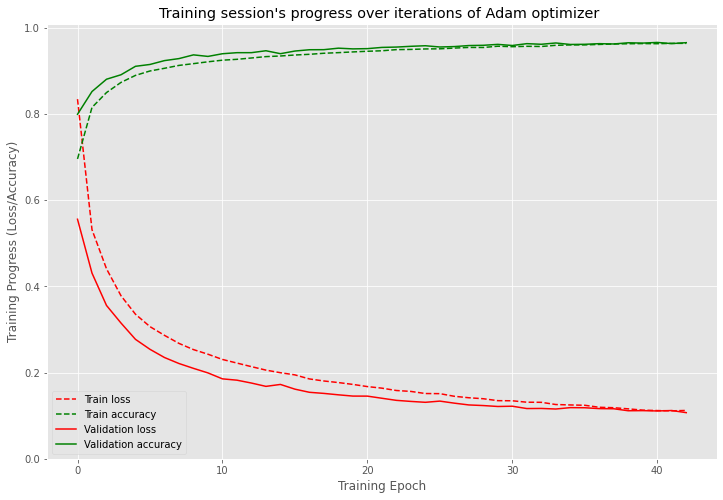

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(np.array(history_1.history['loss']), "r--", label = "Train loss")
plt.plot(np.array(history_1.history['accuracy']), "g--", label = "Train accuracy")
plt.plot(np.array(history_1.history['val_loss']), "r-", label = "Validation loss")
plt.plot(np.array(history_1.history['val_accuracy']), "g-", label = "Validation accuracy")
plt.title("Training session's progress over iterations of Adam optimizer ")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

In [ ]:
loss, accuracy = model_4.evaluate(X_test, y_test, batch_size = 1024, verbose = 1)
print("")
print("Test Accuracy :", accuracy)
print("Test Loss :", loss)

22/22 [==============================] - 3s 129ms/step - loss: 0.1152 - accuracy: 0.9639

Test Accuracy : 0.9639409780502319
Test Loss : 0.11517464369535446


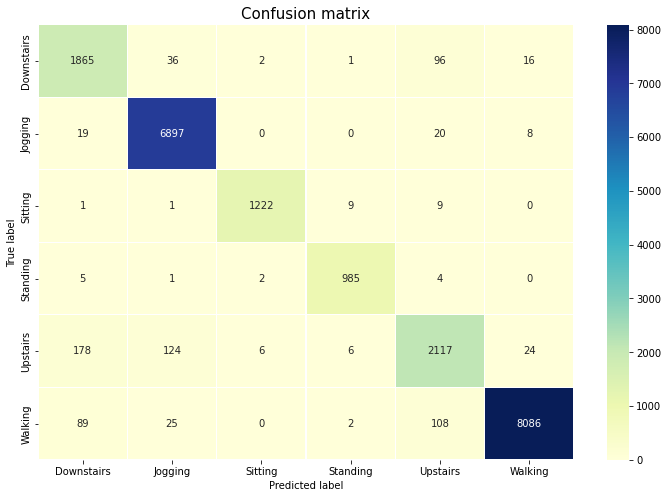

In [ ]:
import seaborn as sns
predictions = model_4.predict(X_test)
LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True,
            linewidths = 0.1, fmt="d", cmap = 'YlGnBu');
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

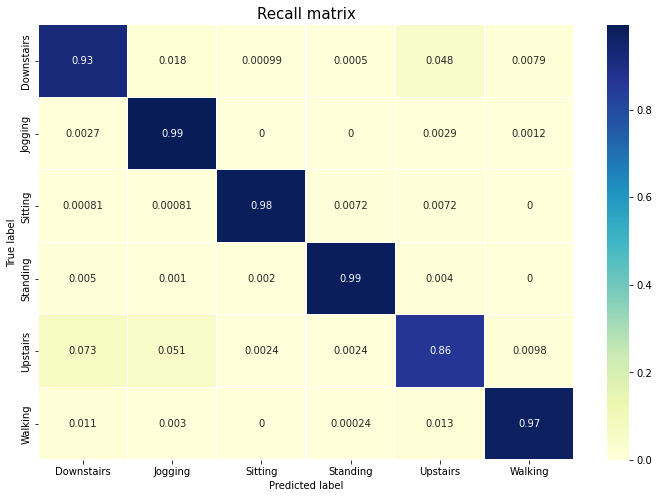

In [ ]:
new_array = []
for i in confusion_matrix:
    new_list = []
    for j in i:
        new_list.append(j/np.sum(i))
    new_array.append(new_list)

#print(new_array)
#print(np.array(new_array).reshape(6, 6))
recall_matrix = np.array(new_array).reshape(6, 6)
# Recall Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(recall_matrix, xticklabels=LABELS, yticklabels=LABELS, 
            linewidths = 0.1, annot = True, cmap = 'YlGnBu')
plt.title('Recall matrix', fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

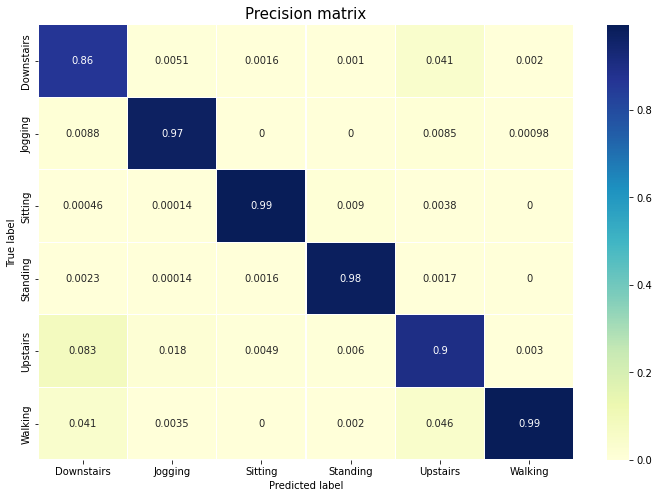

In [ ]:
pr_confusion_matrix = np.transpose(confusion_matrix)
new_array = []
for i in pr_confusion_matrix:
    new_list = []
    for j in i:
        new_list.append(j/np.sum(i))
    new_array.append(new_list)

#print(new_array)
#print(np.array(new_array).reshape(6, 6))
pr_matrix = np.array(new_array).reshape(6, 6)
pr_matrix = np.transpose(pr_matrix)
# Precision Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(pr_matrix, xticklabels=LABELS, yticklabels=LABELS, 
            linewidths = 0.1, annot=True, cmap = 'YlGnBu')
plt.title("Precision matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()